### Overturning due to Ekamn Transport

This notebook, we compute overturning contribution due to Ekman transport. We use zonal surface wind stress to compute Ekman overturning using the following relations,

$$-fv = \frac{-1}{\rho_o}\frac{\partial p}{\partial x} + \frac{1}{\rho_o} \frac{\partial \tau_x}{\partial z} $$
$$-f\int_{x_w}^{x_e}\int_{-h}^{0}v dxdz = \frac{-1}{\rho_o}\int_{x_w}^{x_e}\int_{-h}^{0}\frac{\partial p}{\partial x} dxdz + \frac{1}{\rho_o} \int_{x_w}^{x_e}  \tau_x dx$$
$$-f\left[ \psi_{g} + \psi_{ek} \right] = \frac{-1}{\rho_o}\int_{x_w}^{x_e}\int_{-h}^{0}\frac{\partial p}{\partial x} dxdz + \frac{1}{\rho_o} \int_{x_w}^{x_e}  \tau_x dx$$
$$ \psi_{ek} = \frac{-1}{f\rho_o} \int_{x_w}^{x_e}  \tau_x dx$$




In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

from cmip6_preprocessing.regionmask import merged_mask
import regionmask

import warnings
warnings.filterwarnings("ignore")

In [2]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

In [3]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/"

tauu_NAOp = []
tauu_NAOn = []

var_list_atmos = ['tauu']

NAO_cut = 2.5

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    tau_NAOp = xr.open_mfdataset(ppdir + "*NAOp_tauu*ind_" + str(ind) + ".nc")
    tau_NAOp = tau_NAOp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOp
    
    tau_NAOn = xr.open_mfdataset(ppdir + "*NAOn_tauu*ind_" + str(ind) + ".nc")
    tau_NAOn = tau_NAOn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOn
    
    if(ind > 4):
        tau_NAOn = tau_NAOn.drop('time')
        tau_NAOp = tau_NAOp.drop('time')
    
    tauu_NAOn.append(tau_NAOn)
    tauu_NAOp.append(tau_NAOp)
    
    print(count_NAOp, count_NAOn)

tauu_NAOp = sum(tauu_NAOp)/count_NAOp
tauu_NAOn = sum(tauu_NAOn)/count_NAOn

30 45
68 94
107 139


In [4]:
print(tauu_NAOp)

<xarray.Dataset>
Dimensions:  (time: 101, lat: 324, lon: 432)
Coordinates:
  * time     (time) object 1960-11-16 00:00:00 ... 1969-03-16 00:00:00
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float64 0.0 0.8333 1.667 2.5 ... 356.7 357.5 358.3 359.2
Data variables:
    tauu     (time, lat, lon) float32 dask.array<chunksize=(101, 324, 432), meta=np.ndarray>


### Grid Masks

We create mask for the North Atlantic Ocean, so that only ocean grid points are consistered in the calculation. 

Note that natural earth changes names of some regions, so function `natural_earth_v4_1_0` is being called instead of `natural_earth`. 

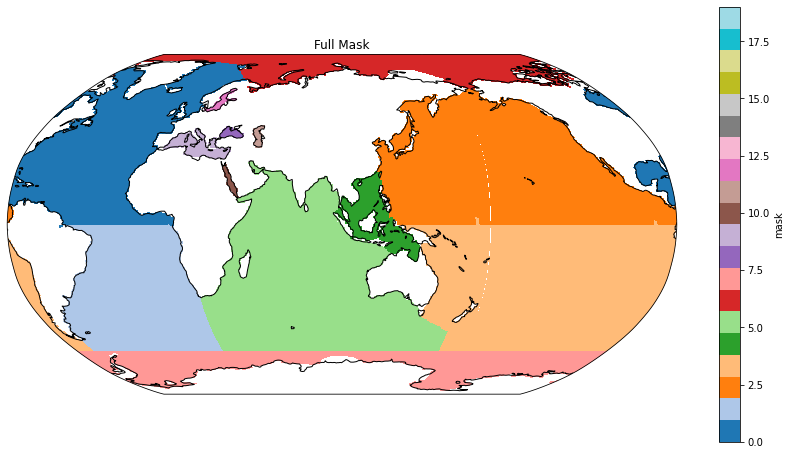

In [5]:
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50

mask_NA = merged_mask(basins, tauu_NAOp, lon_name="lon", lat_name="lat")

kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[15,8], subplot_kw={'projection':ccrs.Robinson(100)})

mask_NA.plot(cmap='tab20', vmin=0, vmax=19, **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

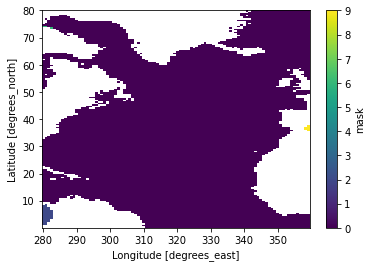

In [13]:
mask_NA.sel(lat=slice(0, 80), lon =slice(280, 360)).plot()

#### Grid info

Before computing $\psi_{ek}$, we need to have grid information and also need to create mask for North Atlantic, so we do not count wind stress values on land.

In [7]:
RAD_EARTH = 6.387e6
RHO_0 = 1035.0

tauu_NAOp['dx'] = (np.mean(tauu_NAOp['lon'].diff('lon')) * 
                   np.cos(tauu_NAOp['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))
tauu_NAOn['dx'] = (np.mean(tauu_NAOn['lon'].diff('lon')) * 
                   np.cos(tauu_NAOn['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))

In [8]:
OMEGA = 2*np.pi / (24*3600.)

int_tau = ((tauu_NAOp['tauu'] * tauu_NAOp['dx']).where(mask_NA==0)).sum('lon')
f = 2 * OMEGA * np.sin(tauu_NAOp['lat'] * np.pi/180.) 
tauu_NAOp['psi_ek'] =  - int_tau / (f * RHO_0)

int_tau = ((tauu_NAOn['tauu'] * tauu_NAOn['dx']).where(mask_NA==0)).sum('lon')
f = 2 * OMEGA * np.sin(tauu_NAOp['lat'] * np.pi/180.) 
tauu_NAOn['psi_ek'] =  - int_tau / (f * RHO_0)


In [9]:
tauu_NAOp['psi_ek']

<xarray.DataArray 'psi_ek' (time: 101, lat: 324)>
dask.array<truediv, shape=(101, 324), dtype=float64, chunksize=(101, 324), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1960-11-16 00:00:00 ... 1969-03-16 00:00:00
  * lat      (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72

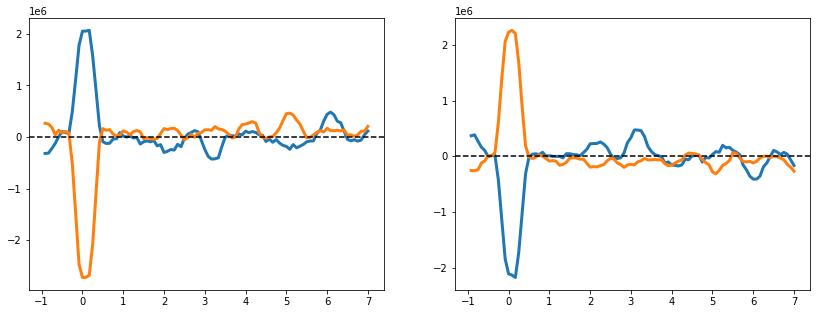

In [10]:
lat_list = [30., 50.] 

fig = plt.figure(figsize=[14,5])

i=1
for lat in lat_list:
    
    plt.subplot(1,2,i)
    tmp = tauu_NAOp['psi_ek'].sel(lat=lat, method='nearest')
    tmp = tmp.rolling(time=6, center=True).mean('time')

    plt.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3.)

    tmp = tauu_NAOn['psi_ek'].sel(lat=lat, method='nearest')
    tmp = tmp.rolling(time=6, center=True).mean('time')

    plt.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3.)

    plt.axhline(y=0., ls='--', color='k')
    
    i=i+1

### Decompose the total streamfunction

We have $\psi'(z)$ computed in depth-space from DePreSys output. Now we decompose the max overturning anomalies into wind-driven (Ekman) and boundary density-driven (geostrophic) components.

$$\psi' = \psi_{ek}' + \psi_{g}'$$

In [11]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'y':10})
ds = ds.get(var_list)

ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_drift = ds_drift.chunk({'y':10})

In [12]:
ds = ds.drop('time_counter') 
ds_drift = ds_drift.drop(['time_counter','start_year'])

ds_anom = ds - ds_drift

psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

ds_anom['psi_anom'] = psi_anom #anomaly in psi max

In [52]:
psi_max= ds_anom['psi_anom'].rename({'time_counter':'time'})
psi_max = psi_max.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)

NAO_cut = 2.5

psi_NAOp = []
psi_NAOn = []

for ind in range(4,13,4):
    
    tmp1 = psi_max.where(NAO_season.isel(time=ind).drop('time') >= NAO_cut)
    tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
    
    psi_NAOp.append(tmp1)
    
    tmp1 = psi_max.where(NAO_season.isel(time=ind).drop('time') <= -NAO_cut)
    tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
    
    psi_NAOn.append(tmp1)

psi_NAOn = xr.concat(psi_NAOn,dim='case')
psi_NAOp = xr.concat(psi_NAOp,dim='case')

print(psi_NAOp)

<xarray.DataArray 'psi_anom' (case: 3, start_year: 57, r: 10, time: 101, y: 451)>
dask.array<concatenate, shape=(3, 57, 10, 101, 451), dtype=float32, chunksize=(1, 57, 10, 101, 10), chunktype=numpy.ndarray>
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
    nav_lat     (y) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
    nav_lon     (y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * y           (y) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
Dimensions without coordinates: case, r, time


In [53]:
lat_val = np.arange(10.,70.,1.)

psi_NAOp_intp = psi_NAOp.mean(['start_year','r','case']).interp(y=lat_val)
psi_NAOn_intp = psi_NAOn.mean(['start_year','r','case']).interp(y=lat_val)

psi_NAOp_intp = psi_NAOp_intp.rename({'y':'lat'})
psi_NAOn_intp = psi_NAOn_intp.rename({'y':'lat'})

psiek_NAOp = tauu_NAOp['psi_ek'].interp(lat=lat_val) / 1.e6 # convert into Sv 
psiek_NAOn = tauu_NAOn['psi_ek'].interp(lat=lat_val) / 1.e6

print(psi_NAOp_intp)
print(psiek_NAOp)

<xarray.DataArray 'psi_anom' (time: 101, lat: 60)>
dask.array<dask_aware_interpnd, shape=(101, 60), dtype=float32, chunksize=(101, 60), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 65.0 66.0 67.0 68.0 69.0
    nav_lon  (lat) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 65.0 66.0 67.0 68.0 69.0
Dimensions without coordinates: time
<xarray.DataArray 'psi_ek' (time: 101, lat: 60)>
dask.array<truediv, shape=(101, 60), dtype=float64, chunksize=(101, 60), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1960-11-16 00:00:00 ... 1969-03-16 00:00:00
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 65.0 66.0 67.0 68.0 69.0


In [54]:
%%time 

psi_NAOp_intp = psi_NAOp_intp.compute()
psi_NAOn_intp = psi_NAOn_intp.compute()

psiek_NAOp = psiek_NAOp.compute()
psiek_NAOn = psiek_NAOn.compute()

CPU times: user 1min 31s, sys: 3min 51s, total: 5min 23s
Wall time: 2min 57s


In [79]:
def psi_compute(psi, psiek):
    
    psi1 = psi.rolling(time=6, center=True).mean('time')
    psi1 = psi1.assign_coords(time=np.arange(0+10,len(psi1.time)+10) / 12 - 2) 
    psi1ek = psiek.drop('time').rolling(time=6, center=True).mean('time')
    psi1ek = psi1ek.assign_coords(time=np.arange(0+10,len(psi1.time)+10) / 12 - 2) 
    psi1g = psi1 - psi1ek
    
    return psi1, psi1ek, psi1g

Text(0.5, 1.0, 'NAO- Conditions, Overturning at $30^{\\circ}$N')

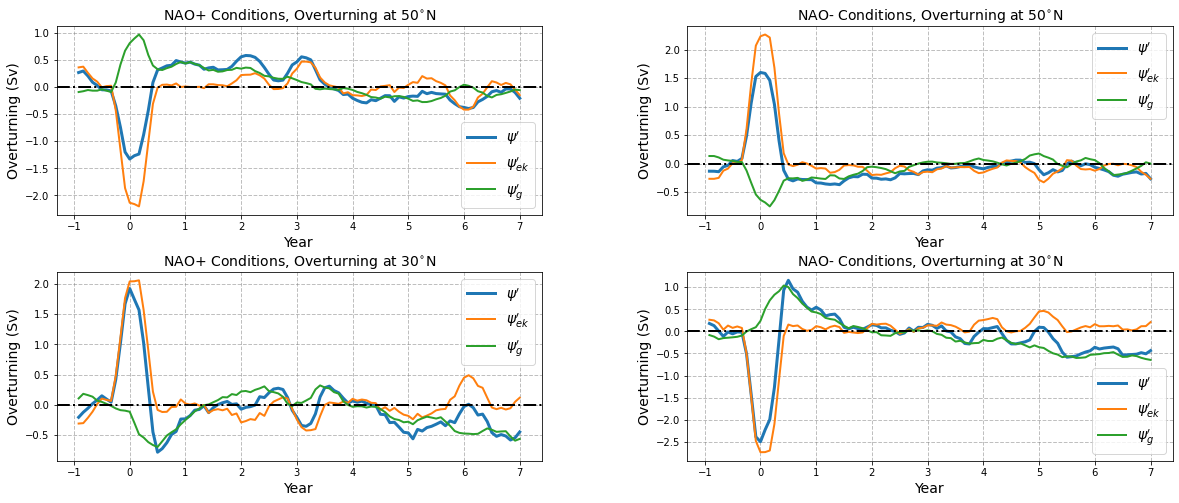

In [74]:
grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,8])

ax = fig.add_subplot(grid1[0, 0])

tmp, tmpek, tmpg = psi_compute(psi_NAOp_intp.sel(lat=50.), psiek_NAOp.sel(lat=50.))
ax.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3., label=r'$\psi^{\prime}$')
ax.plot(np.arange(0+10,len(tmpek.time)+10) / 12 - 2, tmpek, lw=2., label=r'$\psi^{\prime}_{ek}$')
ax.plot(np.arange(0+10,len(tmpg.time)+10) / 12 - 2, tmpg, lw=2., label=r'$\psi^{\prime}_g$')
    
ax.axhline(y=0, ls='-.', lw=2., color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_ylabel('Overturning (Sv)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('NAO+ Conditions, Overturning at $50^{\circ}$N', fontsize=14)

ax = fig.add_subplot(grid1[0, 1])

tmp, tmpek, tmpg = psi_compute(psi_NAOn_intp.sel(lat=50.), psiek_NAOn.sel(lat=50.))
ax.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3., label=r'$\psi^{\prime}$')
ax.plot(np.arange(0+10,len(tmpek.time)+10) / 12 - 2, tmpek, lw=2., label=r'$\psi^{\prime}_{ek}$')
ax.plot(np.arange(0+10,len(tmpg.time)+10) / 12 - 2, tmpg, lw=2., label=r'$\psi^{\prime}_g$')
    
ax.axhline(y=0, ls='-.', lw=2., color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_ylabel('Overturning (Sv)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('NAO- Conditions, Overturning at $50^{\circ}$N', fontsize=14)


# ------------------------- 30 N ---------------------- #
ax = fig.add_subplot(grid1[1, 0])

tmp, tmpek, tmpg = psi_compute(psi_NAOp_intp.sel(lat=30.), psiek_NAOp.sel(lat=30.))
ax.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3., label=r'$\psi^{\prime}$')
ax.plot(np.arange(0+10,len(tmpek.time)+10) / 12 - 2, tmpek, lw=2., label=r'$\psi^{\prime}_{ek}$')
ax.plot(np.arange(0+10,len(tmpg.time)+10) / 12 - 2, tmpg, lw=2., label=r'$\psi^{\prime}_g$')
    
ax.axhline(y=0, ls='-.', lw=2., color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_ylabel('Overturning (Sv)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('NAO+ Conditions, Overturning at $30^{\circ}$N', fontsize=14)

ax = fig.add_subplot(grid1[1, 1])

tmp, tmpek, tmpg = psi_compute(psi_NAOn_intp.sel(lat=30.), psiek_NAOn.sel(lat=30.))
ax.plot(np.arange(0+10,len(tmp.time)+10) / 12 - 2, tmp, lw=3., label=r'$\psi^{\prime}$')
ax.plot(np.arange(0+10,len(tmpek.time)+10) / 12 - 2, tmpek, lw=2., label=r'$\psi^{\prime}_{ek}$')
ax.plot(np.arange(0+10,len(tmpg.time)+10) / 12 - 2, tmpg, lw=2., label=r'$\psi^{\prime}_g$')
    
ax.axhline(y=0, ls='-.', lw=2., color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_ylabel('Overturning (Sv)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('NAO- Conditions, Overturning at $30^{\circ}$N', fontsize=14)


Text(0.5, 1.0, 'NAO- Conditions, $\\psi^{\\prime}$')

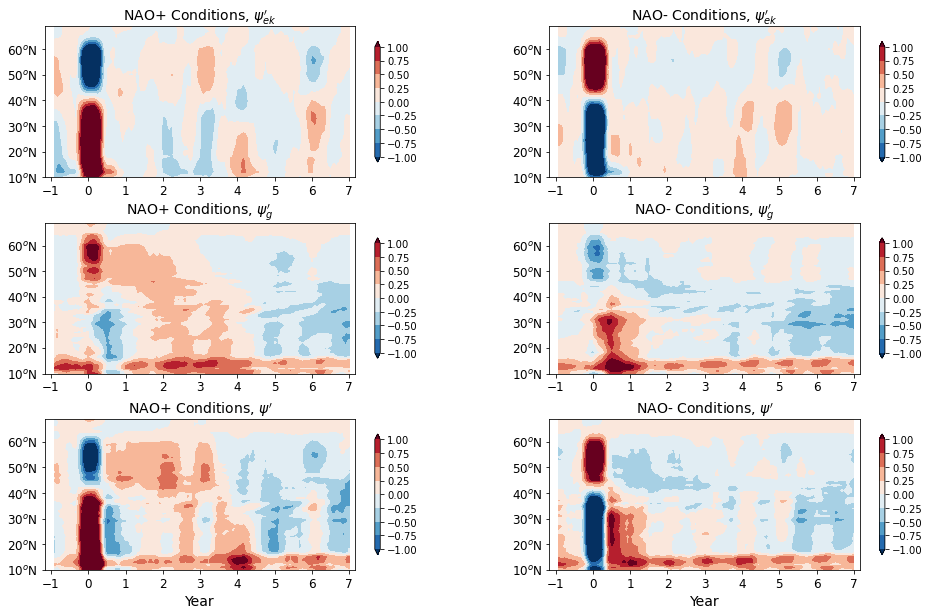

In [90]:
# ------------------------- Contour plot ---------------------- #

grid1 = plt.GridSpec(3, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,10])

tmp, tmpek, tmpg = psi_compute(psi_NAOp_intp, psiek_NAOp)

ax = fig.add_subplot(grid1[0, 0])
p = tmpek.plot.contourf(ax=ax, x='time', y='lat', vmin=-1.0, vmax=1.0, levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title(r'NAO+ Conditions, $\psi^{\prime}_{ek}$', fontsize=14)

ax = fig.add_subplot(grid1[1, 0])
p = tmpg.plot.contourf(ax=ax, x='time', y='lat', vmin=-1., vmax=1., levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title(r'NAO+ Conditions, $\psi^{\prime}_{g}$', fontsize=14)

ax = fig.add_subplot(grid1[2, 0])
p = tmp.plot.contourf(ax=ax, x='time', y='lat', vmin=-1., vmax=1., levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(r'NAO+ Conditions, $\psi^{\prime}$', fontsize=14)

tmp, tmpek, tmpg = psi_compute(psi_NAOn_intp, psiek_NAOn)

ax = fig.add_subplot(grid1[0, 1])
p = tmpek.plot.contourf(ax=ax, x='time', y='lat', vmin=-1.0, vmax=1.0, levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title(r'NAO- Conditions, $\psi^{\prime}_{ek}$', fontsize=14)

ax = fig.add_subplot(grid1[1, 1])
p = tmpg.plot.contourf(ax=ax, x='time', y='lat', vmin=-1., vmax=1., levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title(r'NAO- Conditions, $\psi^{\prime}_{g}$', fontsize=14)

ax = fig.add_subplot(grid1[2, 1])
p = tmp.plot.contourf(ax=ax, x='time', y='lat', vmin=-1., vmax=1., levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8)
plt.yticks(np.arange(10,70,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(r'NAO- Conditions, $\psi^{\prime}$', fontsize=14)